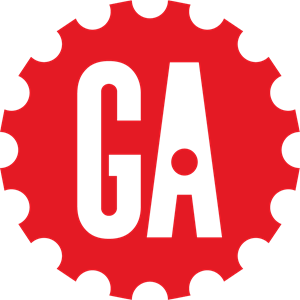

# Capstone Project: ML, Brain Tumors & MRI

Constance Lin | DSI-41

<b> Notebook 2: Retrieval-Augmented Question Answer (QA) model on PDF documents </b>

<br>

<b> Contents of notebook: </b>
1. Installations
    * Pinecone
    * Langchain
    * pyPDF
2. Document Loading & Splitting
3. Vector Store & Embeddings
4. Retrieval with QA model
5. Convert code to a function for Streamlit

This notebook demonstrates the steps to do Question-Answer on PDF documents using Langchain and Pinecone. In Part 4, it demonstrates a query asked and an answer was provided by retrieving information from the PDFs that were given to the model. 

### Part 1: Installations 

Note that most of them just have to be done for the very first time we are running this code.

<b> Pinecone, Langchain & OpenAI installations </b>

In [1]:
# install pinecone client
# !pip install pinecone-client

# install langchain and openai 
# !pip install -U langchain-openai
# !pip install -U langchain-community

# for streamlit
# !pip install streamlit

<b> Document loaders installations </b>

In [ ]:
# this is for open pdf documents on python
# !pip install pypdf

### Part 2: Document Loading & Splitting

<b> Load in libraries </b>

In [3]:
# import the necessary libraries
import os
import pinecone
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Pinecone as PineConeStore # so that it does not clash with pinecone library
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chains import RetrievalQA
from dotenv import load_dotenv

load_dotenv()

In [13]:
# load the pdf
loader = PyPDFLoader(r"../documents/document.pdf") # replace the string with the relative path of where your pdf document is stored 
loaded_pdf = loader.load()

# pyPDFloader will split the pdf into pages
print (f'You have {len(loaded_pdf)} page(s) in your data')
print (f'There are {len(loaded_pdf[0].page_content)} characters in your document')

# split the loaded pdf into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1024, chunk_overlap = 150, separators = ["\n\n", "\n", " ", ""]) 
documents = text_splitter.split_documents(loaded_pdf)

You have 7 page(s) in your data
There are 4935 characters in your document


**Note:**

Using the example pdf provided in `loader`, checking with the actual document, it indeed has 7 pages. From here, we know that PyPDFloader has split it by pages.

### Part 3: Vector Store & Embeddings

In [4]:
# initialize OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") 
os.environ[OPENAI_API_KEY] = OPENAI_API_KEY

In [5]:
# create embedding variable using OpenAI
embeddings = OpenAIEmbeddings(openai_api_key = OPENAI_API_KEY)

In [6]:
# initialize pinecone
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
os.environ[PINECONE_API_KEY] = PINECONE_API_KEY
pinecone.Pinecone(api_key = PINECONE_API_KEY)

# instantiate the index
# my_index_name is taken from the index name in my pinecone account
my_index_name = "capstone-project" # replace string with your own project name

**Note:**

"OPENAI_API_KEY" is obtained by going to the openAI website - set up an account and get a free api key. 
"PINECONE_API_KEY" is obtained by going to pinecone website - set up an account and get a free api key. Before moving to the next step, on the website we need to create a project. After that, go to the "Indexes" tab and create an index. 

In our case:
* Index name: capstone-project
* Metric: cosine (because this follows ada-002 model which is trained on cosine similarities)
    * recommended for semantic search
* Dimension: 1536 (also following ada-002 requirements)
* Pod type, Environment, Cloud, Region: by default on pinecone as per their starter account 

Once this is done, move on to the code below. 

In [6]:
# create a variable that will embed our text onto pinecone vector database
# only use this if it is the first time you are loading the pdf onto pinecone vector database
docsearch = PineConeStore.from_texts([t.page_content for t in documents], embeddings, index_name = my_index_name)

**Note:**

At this point, if we were to check our pinecone account, it should show new vectors uploaded which are  from this particular pdf. You can repeat the above steps until all required PDFs have been stored in pinecone vector database.

### Part 4: Retrieval & Question-Answer

In [7]:
# if already have existing embeddings from the database, use this
# string follows the index name of the project in your own pinecone account
docsearch_recall = PineConeStore.from_existing_index("capstone-project", embeddings)

In [10]:
# define the llm model used
llm = ChatOpenAI(model_name = "gpt-3.5-turbo", temperature = 0)
chain = RetrievalQA.from_chain_type(llm, 
                                    chain_type = "stuff",
                                    retriever = docsearch_recall.as_retriever())

# what is our query
query = "What is Lo Hei in relation to Magnetic Resonance Imaging?" # put in your own query

# get our answer
chain.run(query)

'Lo Hei, in the context of Magnetic Resonance Imaging (MRI), refers to a study conducted to evaluate the projectile risk of smaller ferromagnetic objects inside MRI scanners. The study aimed to provide local relevance to practice in Singapore by assessing the potential risks associated with objects that could be carried by individuals or found near an MRI scanning room. The study highlighted the importance of understanding the ferromagnetic activity of various objects to prevent accidents and ensure safety in MRI environments.'

In [12]:
# testing - ask another question, phrased in a different way
# what is our query
query = "What is Lo Hei? Answer based on the information you have been given."

# get our answer
chain.run(query)

'Based on the information provided, Lo Hei seems to refer to the Local cOinage and Hospital Equipment Index project conducted by Ong et al. in the Singapore Medical Journal. The project involved testing the projectile distance of Singapore coinage and healthcare-related equipment in a 3T magnetic resonance imaging scanner.'

**Note:**

Based on the individual steps, we are able to take a pdf, split it into chunks and successfully vectorize it iand store it open Pinecone Vector database. After that we are able to recall the vector to answer specific questions based on what we have given to the model.

**Summary:**

Comparison to ChatGPT have shown that our QA RAG model gives us a better answer when asked the same question, "What is Lo Hei in relation to Magnetic Resonance Imaging?"

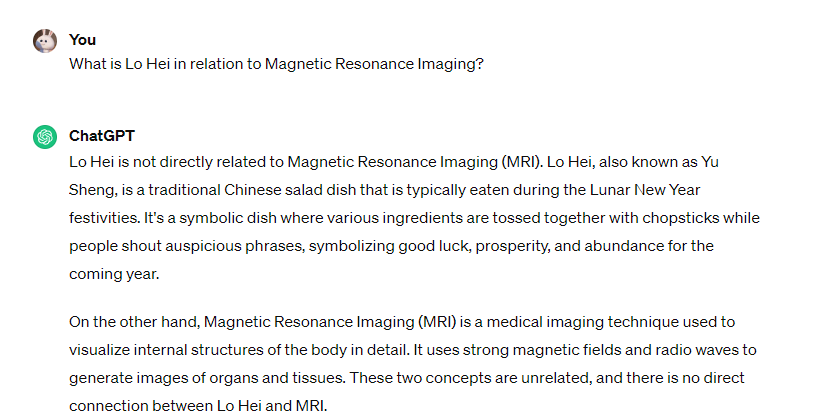

### Part 5: Convert code to a function for Streamlit

Since we have demonstrated that in Part 1 to Part 4 that the code works, now we will convert it into a function for ease of deployment onto Streamlit - the file is labelled as  `streamlit_demo_mvp.py` in the `streamlit_demo` folder.

An example screenshot is shown as follows, with a chatgpt response to compare:

![rag_model_example](../images/rag_example.png)

![chatgpt_response](../images/chatgpt_ans.png)